In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from LearningAlgorithms import ClassificationAlgorithms
from sklearn.metrics import accuracy_score, confusion_matrix
import itertools

# Outlier Removal

In [ ]:
df = pd.read_csv("final_data.csv", index_col=0)
df.head(5)

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set
epoch (ms),,,,,,,,,,
2019-01-11 15:08:05.200,0.013500,0.977000,-0.071000,-1.8904,2.4392,0.9388,B,bench,heavy,30
2019-01-11 15:08:05.400,-0.001500,0.970500,-0.079500,-1.6826,-0.8904,2.1708,B,bench,heavy,30
2019-01-11 15:08:05.600,0.001333,0.971667,-0.064333,2.5608,-0.2560,-1.4146,B,bench,heavy,30
2019-01-11 15:08:05.800,-0.024000,0.957000,-0.073500,8.0610,-4.5244,-2.0730,B,bench,heavy,30
2019-01-11 15:08:06.000,-0.028000,0.957667,-0.115000,2.4390,-1.5486,-3.6098,B,bench,heavy,30


In [ ]:
plt.rcParams['figure.figsize'] = (20, 5)
plt.rcParams['figure.dpi'] = 100

array([<Axes: title={'center': 'acc_x'}, xlabel='[label]'>,
       <Axes: title={'center': 'acc_y'}, xlabel='[label]'>,
       <Axes: title={'center': 'acc_z'}, xlabel='[label]'>], dtype=object)

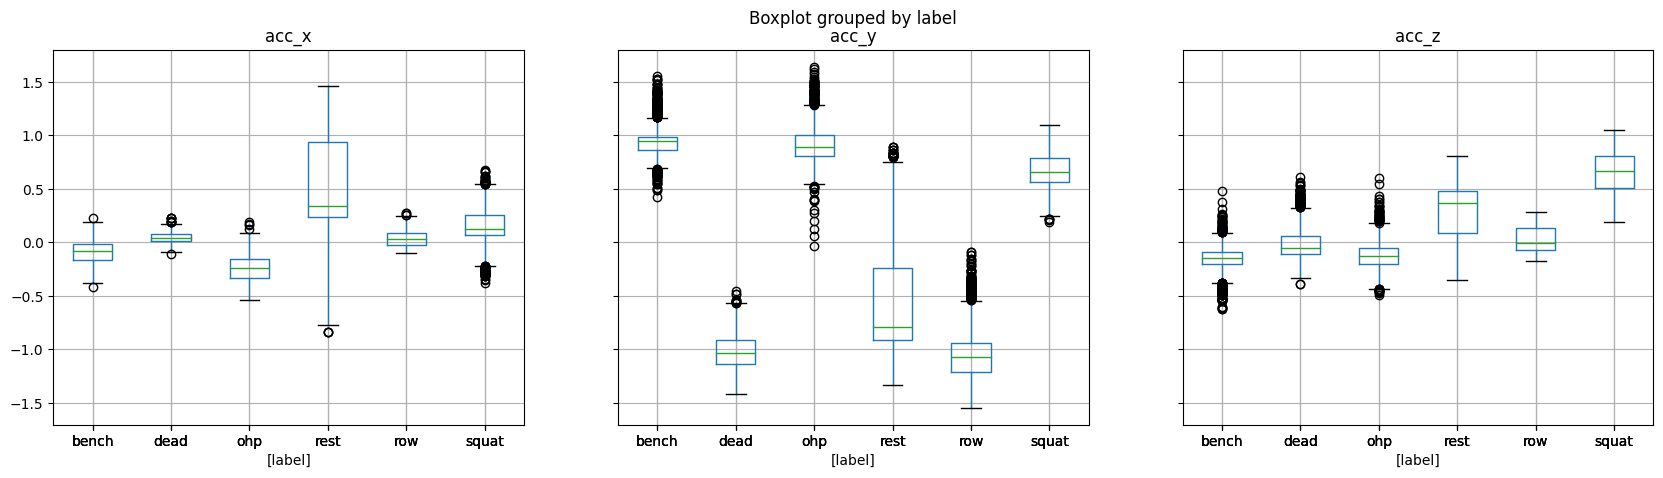

In [ ]:
df[list(df.columns)[:3] + ['label']].boxplot(by='label', layout=(1,3))

array([<Axes: title={'center': 'gyr_x'}, xlabel='[label]'>,
       <Axes: title={'center': 'gyr_y'}, xlabel='[label]'>,
       <Axes: title={'center': 'gyr_z'}, xlabel='[label]'>], dtype=object)

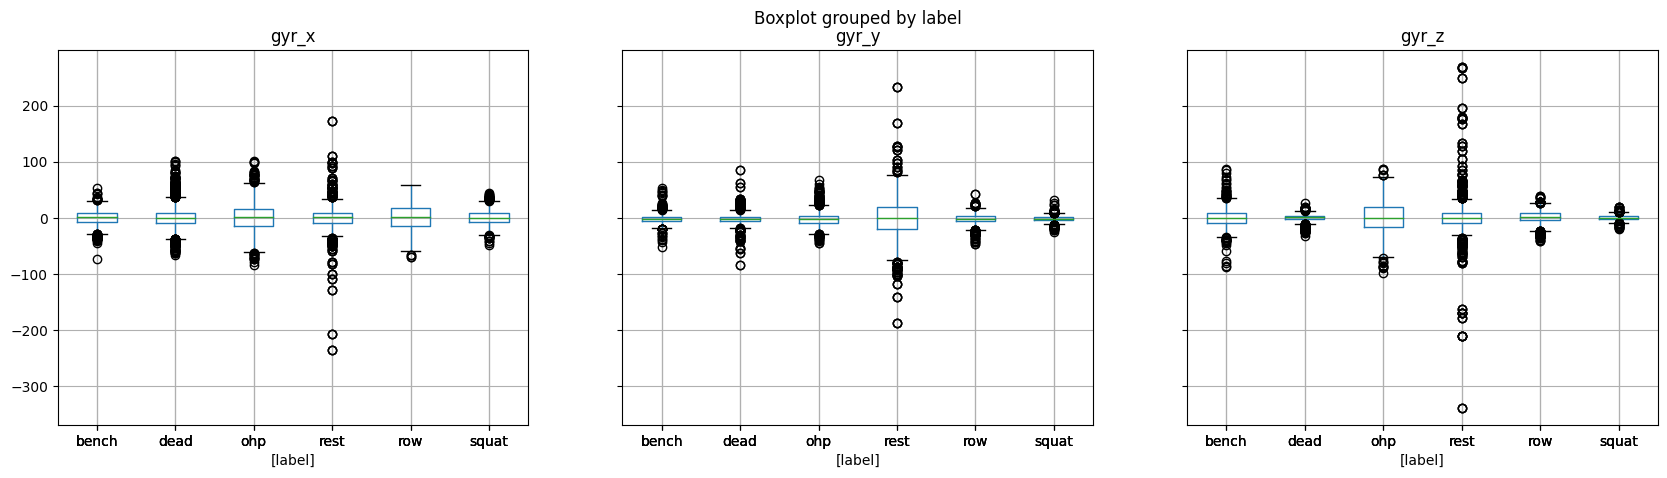

In [ ]:
df[list(df.columns)[3:6] + ['label']].boxplot(by='label', layout=(1,3))

In [ ]:
def plot_binary_outliers(dataset, col, outlier_col, reset_index):
    """ Plot outliers in case of a binary outlier score. Here, the col specifies the real data
    column and outlier_col the columns with a binary value (outlier or not).

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): Column that you want to plot
        outlier_col (string): Outlier column marked with true/false
        reset_index (bool): whether to reset the index for plotting
    """

    # Taken from: https://github.com/mhoogen/ML4QS/blob/master/Python3Code/util/VisualizeDataset.py

    dataset = dataset.dropna(axis=0, subset=[col, outlier_col])
    dataset[outlier_col] = dataset[outlier_col].astype("bool")

    if reset_index:
        dataset = dataset.reset_index()

    fig, ax = plt.subplots()

    plt.xlabel("samples")
    plt.ylabel("value")

    # Plot non outliers in default color
    ax.plot(
        dataset.index[~dataset[outlier_col]],
        dataset[col][~dataset[outlier_col]],
        "+",
    )
    # Plot data points that are outliers in red
    ax.plot(
        dataset.index[dataset[outlier_col]],
        dataset[col][dataset[outlier_col]],
        "r+",
    )

    plt.legend(
        ["outlier " + col, "no outlier " + col],
        loc="upper center",
        ncol=2,
        fancybox=True,
        shadow=True,
    )
    plt.show()

In [ ]:
def mark_outliers_iqr(dataset, col):
    """Function to mark values as outliers using the IQR method.

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): The column you want apply outlier detection to

    Returns:
        pd.DataFrame: The original dataframe with an extra boolean column
        indicating whether the value is an outlier or not.
    """

    dataset = dataset.copy()

    Q1 = dataset[col].quantile(0.25)
    Q3 = dataset[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    dataset[col + "_outlier"] = (dataset[col] < lower_bound) | (
        dataset[col] > upper_bound
    )

    return dataset

In [ ]:
for col in list(df.columns)[:6]:
    dataset = mark_outliers_iqr(df, col=col)
    plot_binary_outliers(dataset, col=col, outlier_col= col+"_outlier", reset_index=True)

NameError: ignored

In [ ]:
df[list(df.columns)[:3] + ['label']].plot.hist(by='label', layout=(3,3), figsize=(20,20))

NameError: ignored

array([[<Axes: title={'center': 'bench'}, ylabel='Frequency'>,
        <Axes: title={'center': 'dead'}, ylabel='Frequency'>,
        <Axes: title={'center': 'ohp'}, ylabel='Frequency'>],
       [<Axes: title={'center': 'rest'}, ylabel='Frequency'>,
        <Axes: title={'center': 'row'}, ylabel='Frequency'>,
        <Axes: title={'center': 'squat'}, ylabel='Frequency'>]],
      dtype=object)

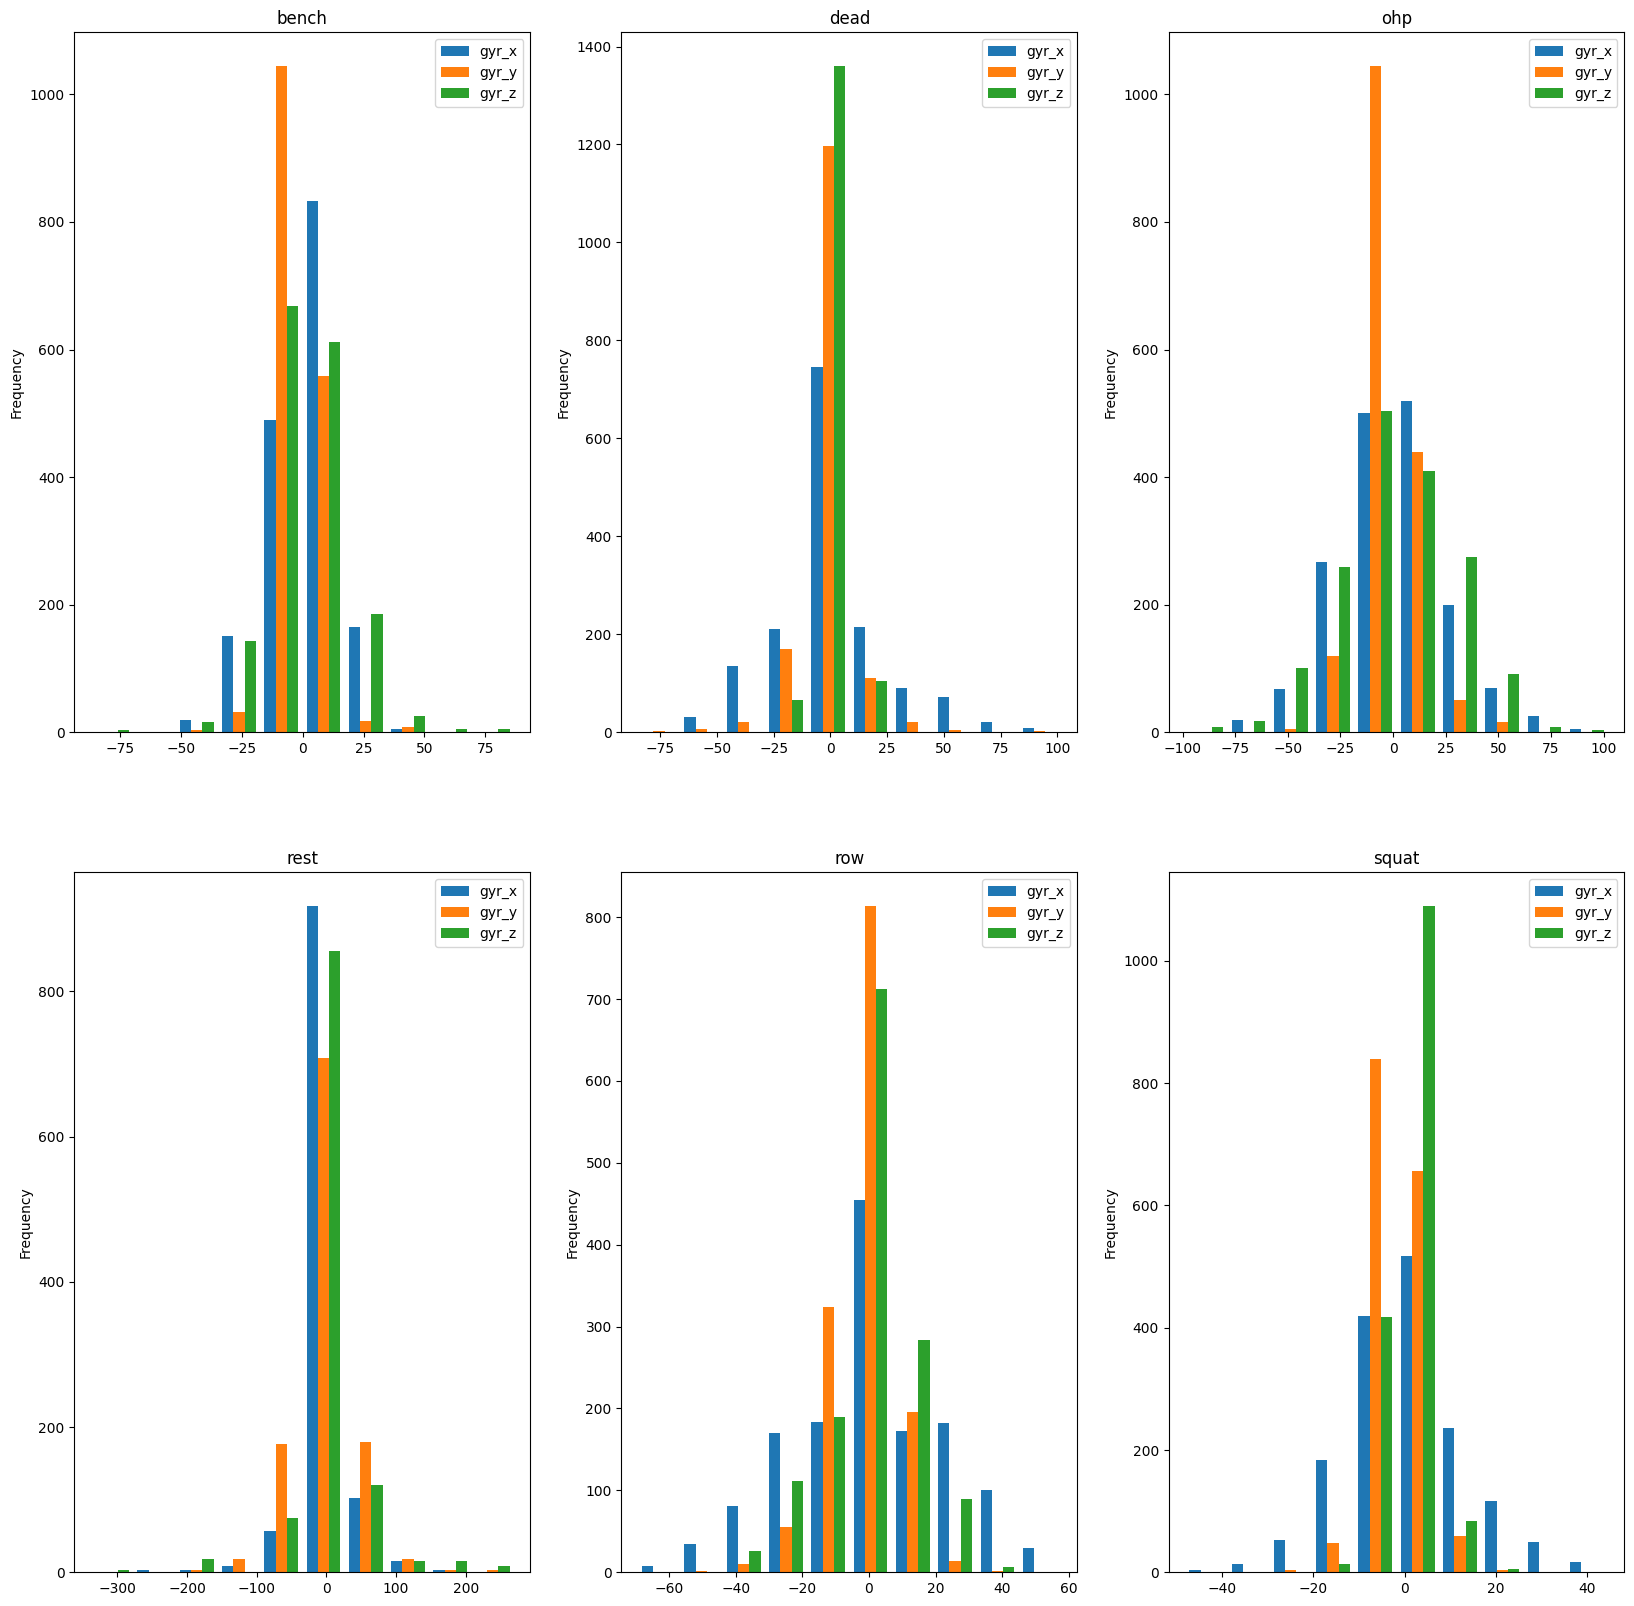

In [ ]:
df[list(df.columns)[3:6] + ['label']].plot.hist(by='label', layout=(2,3), figsize=(20,20))

In [ ]:
def mark_outliers_chauvenet(dataset, col, C=2):
    """Finds outliers in the specified column of datatable and adds a binary column with
    the same name extended with '_outlier' that expresses the result per data point.

    Taken from: https://github.com/mhoogen/ML4QS/blob/master/Python3Code/Chapter3/OutlierDetection.py

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): The column you want apply outlier detection to
        C (int, optional): Degree of certainty for the identification of outliers given the assumption
                           of a normal distribution, typicaly between 1 - 10. Defaults to 2.

    Returns:
        pd.DataFrame: The original dataframe with an extra boolean column
        indicating whether the value is an outlier or not.
    """

    dataset = dataset.copy()
    # Compute the mean and standard deviation.
    mean = dataset[col].mean()
    std = dataset[col].std()
    N = len(dataset.index)
    criterion = 1.0 / (C * N)

    # Consider the deviation for the data points.
    deviation = abs(dataset[col] - mean) / std

    # Express the upper and lower bounds.
    low = -deviation / math.sqrt(C)
    high = deviation / math.sqrt(C)
    prob = []
    mask = []

    # Pass all rows in the dataset.
    for i in range(0, len(dataset.index)):
        # Determine the probability of observing the point
        prob.append(
            1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
        )
        # And mark as an outlier when the probability is below our criterion.
        mask.append(prob[i] < criterion)
    dataset[col + "_outlier"] = mask
    return dataset

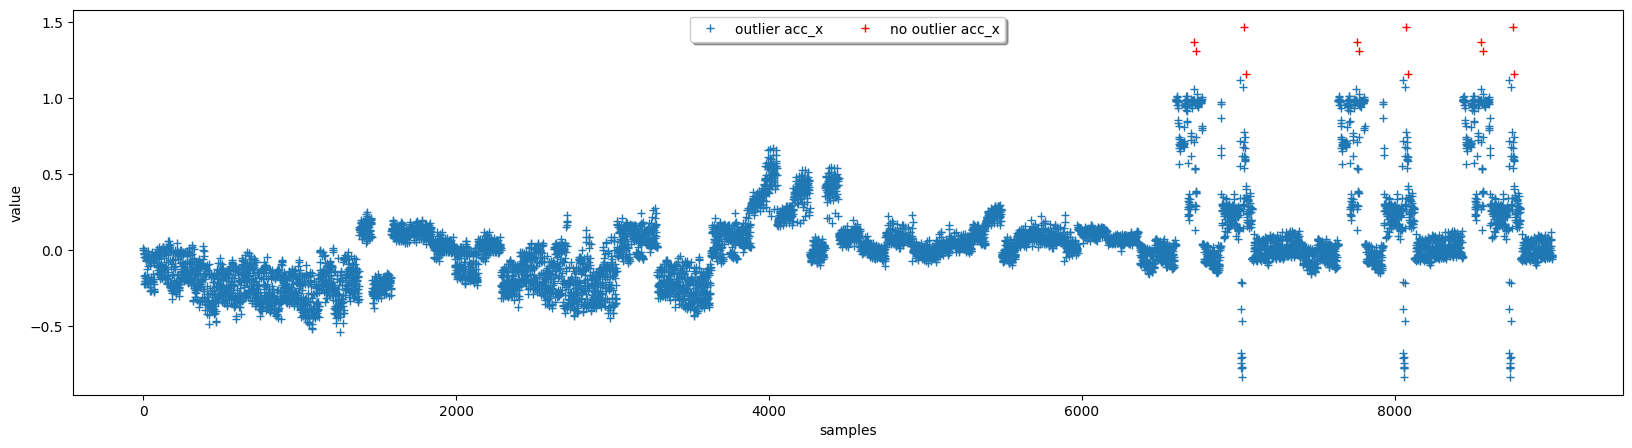

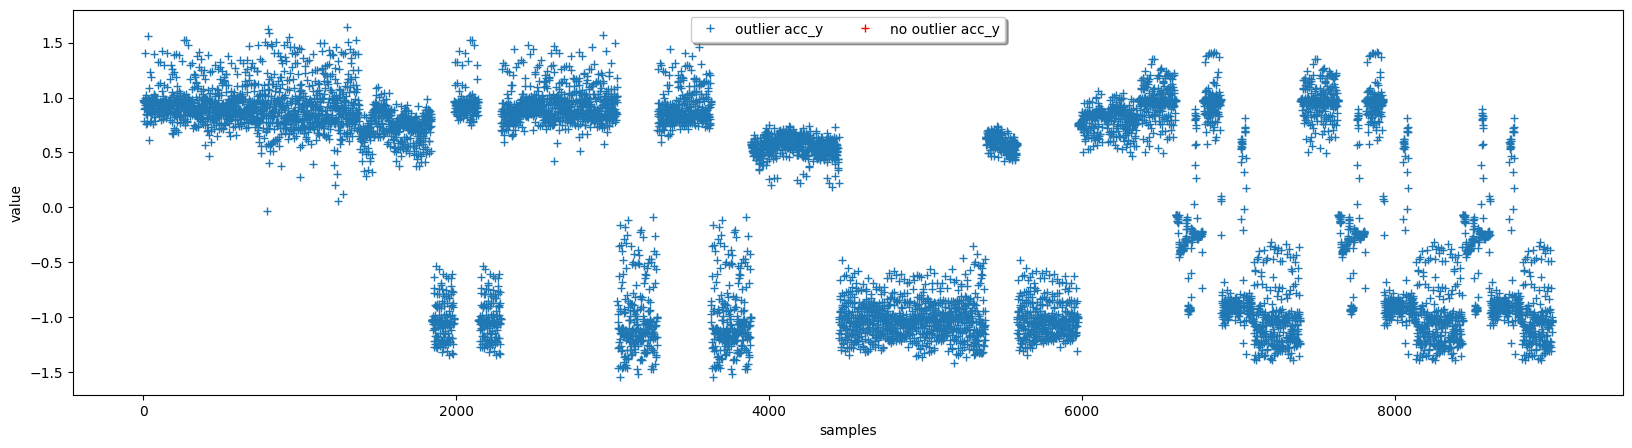

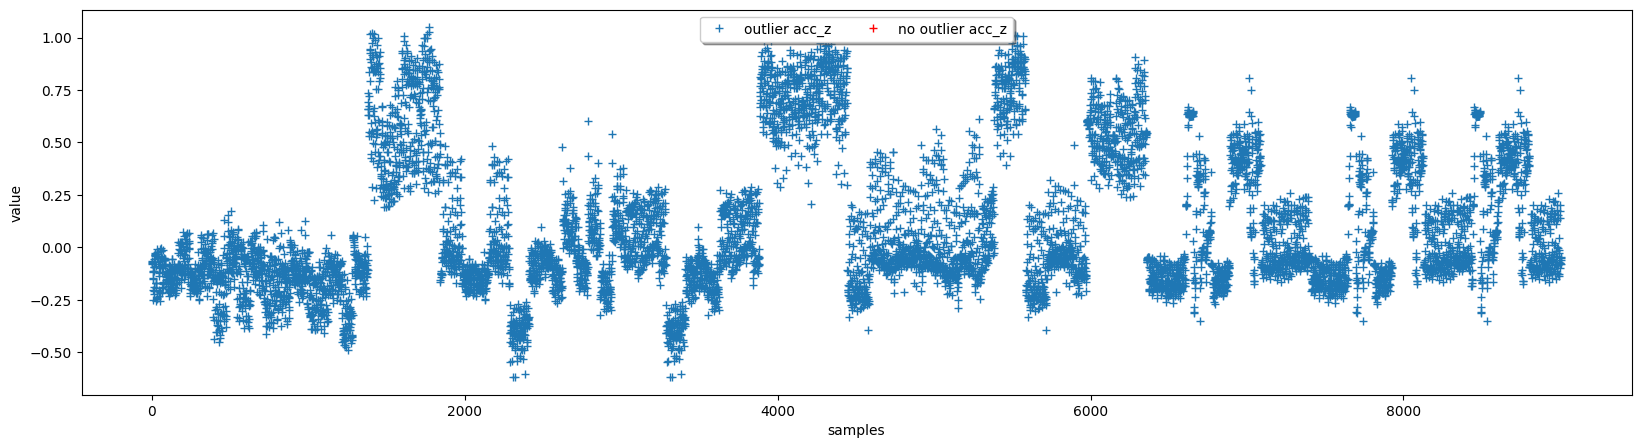

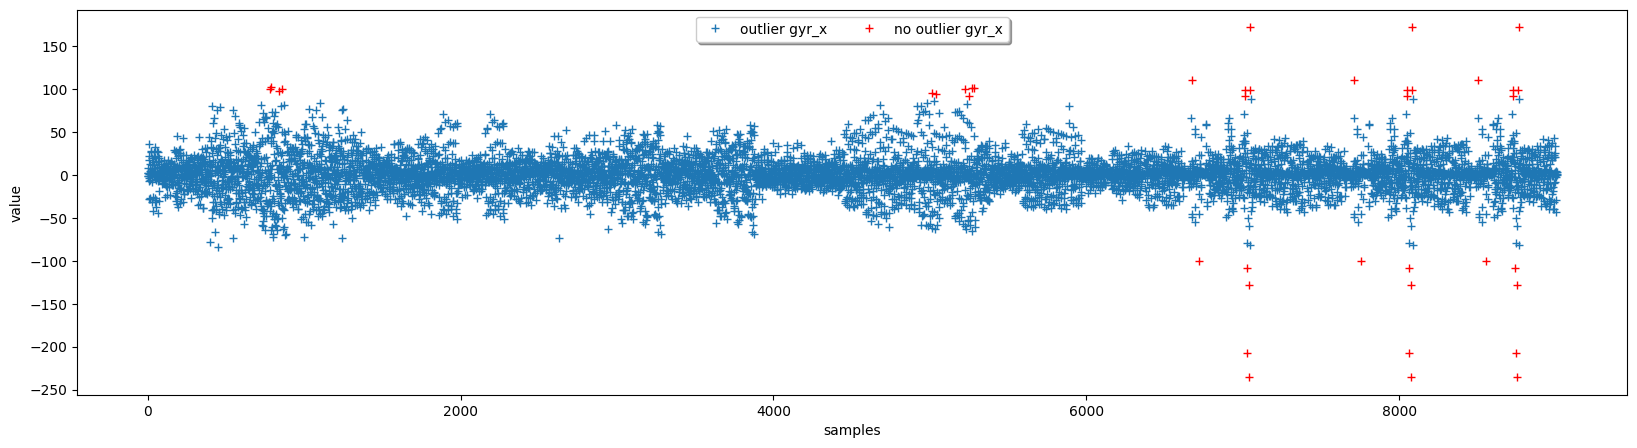

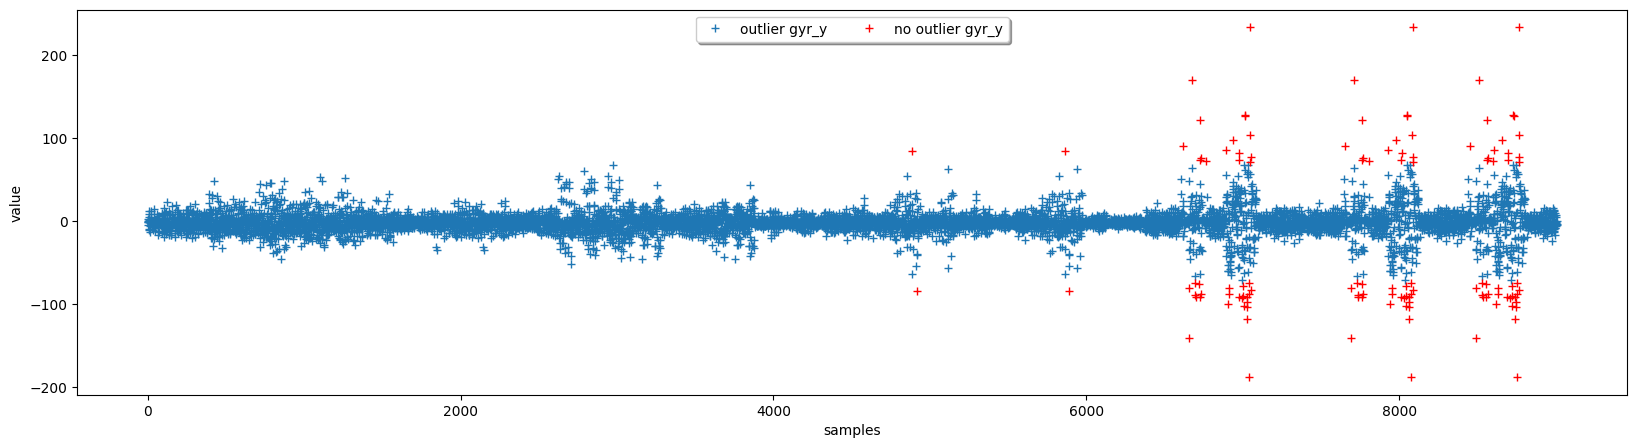

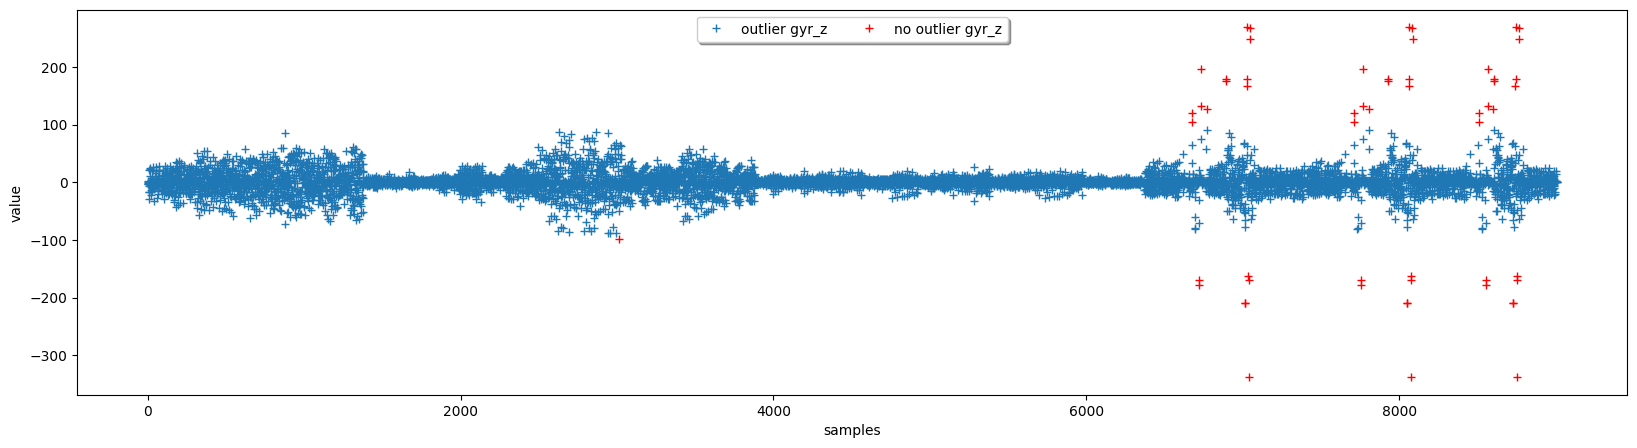

In [ ]:
for col in list(df.columns)[:6]:
    dataset = mark_outliers_chauvenet(df, col=col)
    plot_binary_outliers(dataset, col=col, outlier_col= col+"_outlier", reset_index=True)

In [ ]:
def mark_outliers_lof(dataset, columns, n=20):
    """Mark values as outliers using LOF

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): The column you want apply outlier detection to
        n (int, optional): n_neighbors. Defaults to 20.

    Returns:
        pd.DataFrame: The original dataframe with an extra boolean column
        indicating whether the value is an outlier or not.
    """

    dataset = dataset.copy()

    lof = LocalOutlierFactor(n_neighbors=n)
    data = dataset[columns]
    outliers = lof.fit_predict(data)
    X_scores = lof.negative_outlier_factor_

    dataset["outlier_lof"] = outliers == -1
    return dataset, outliers, X_scores

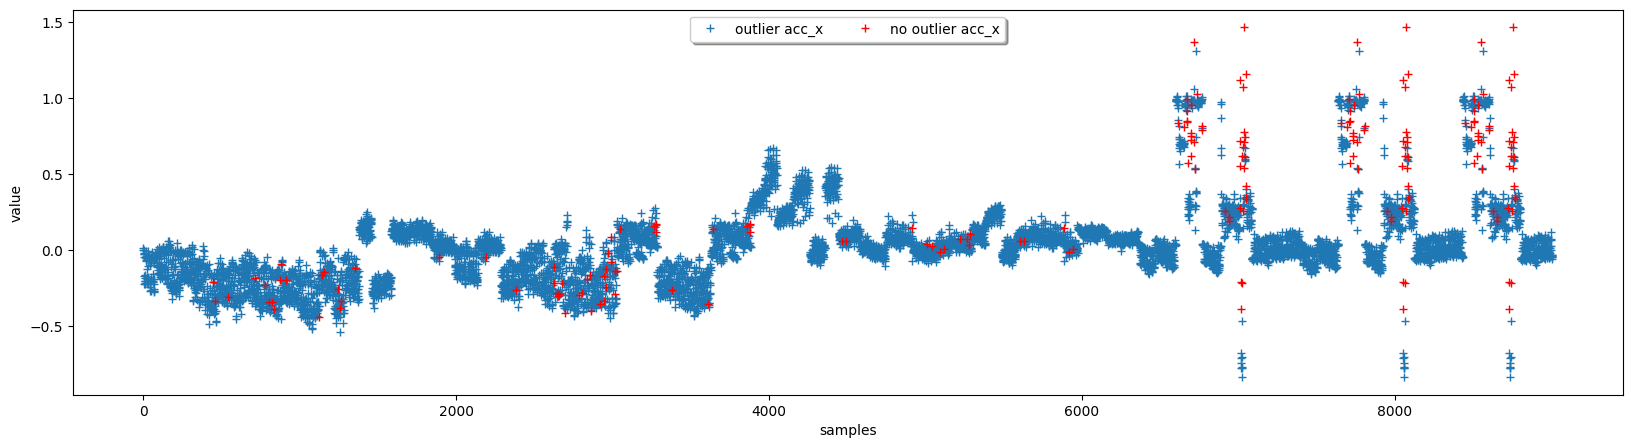

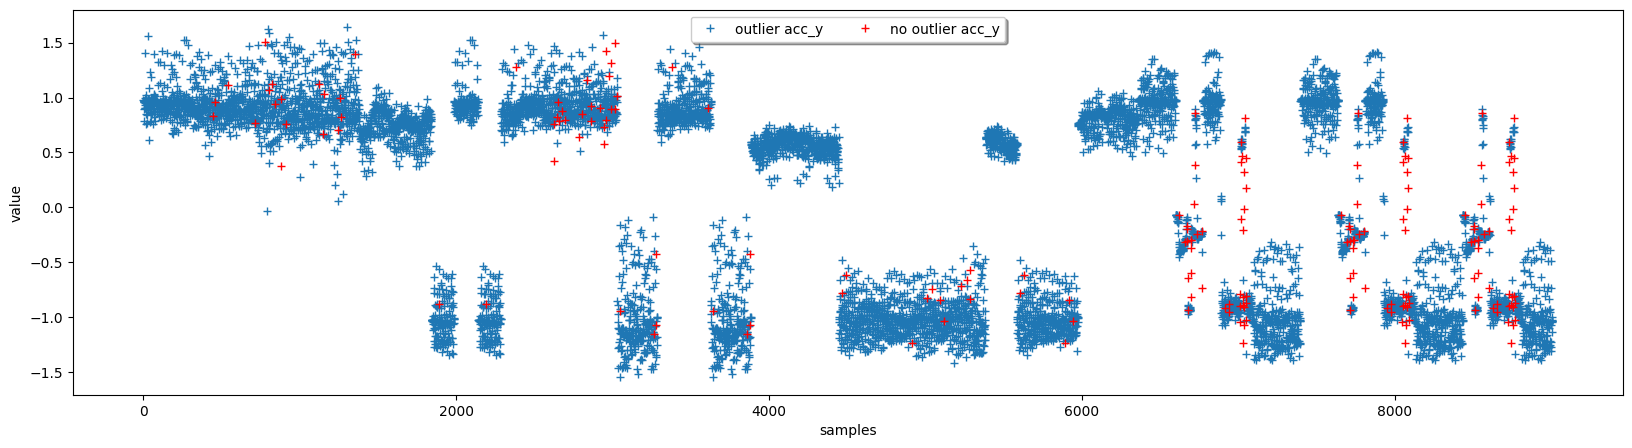

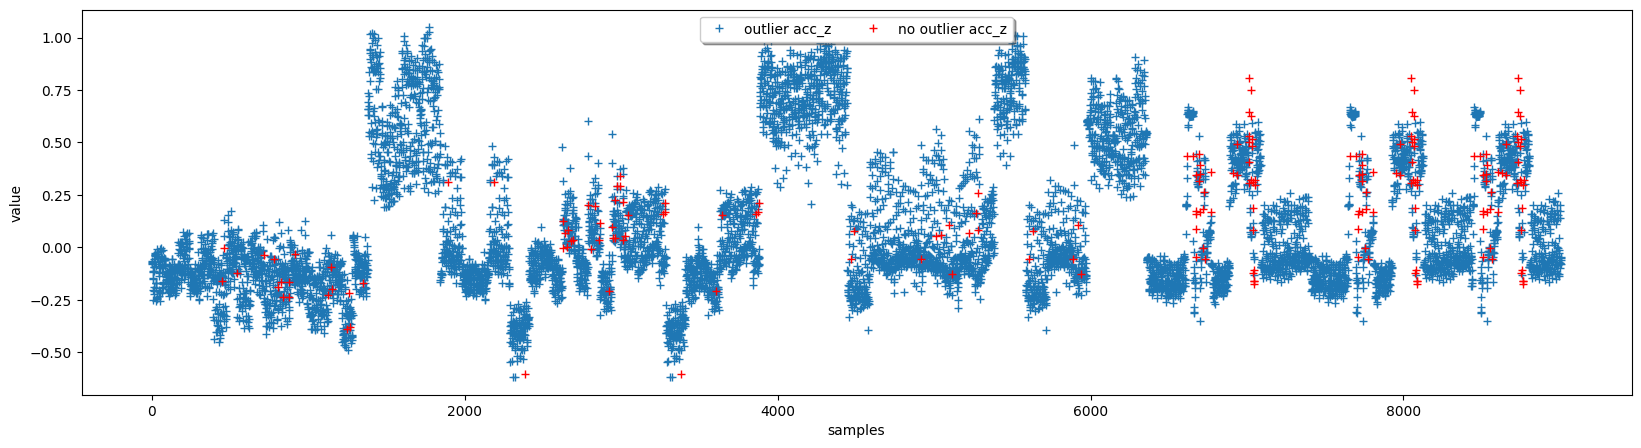

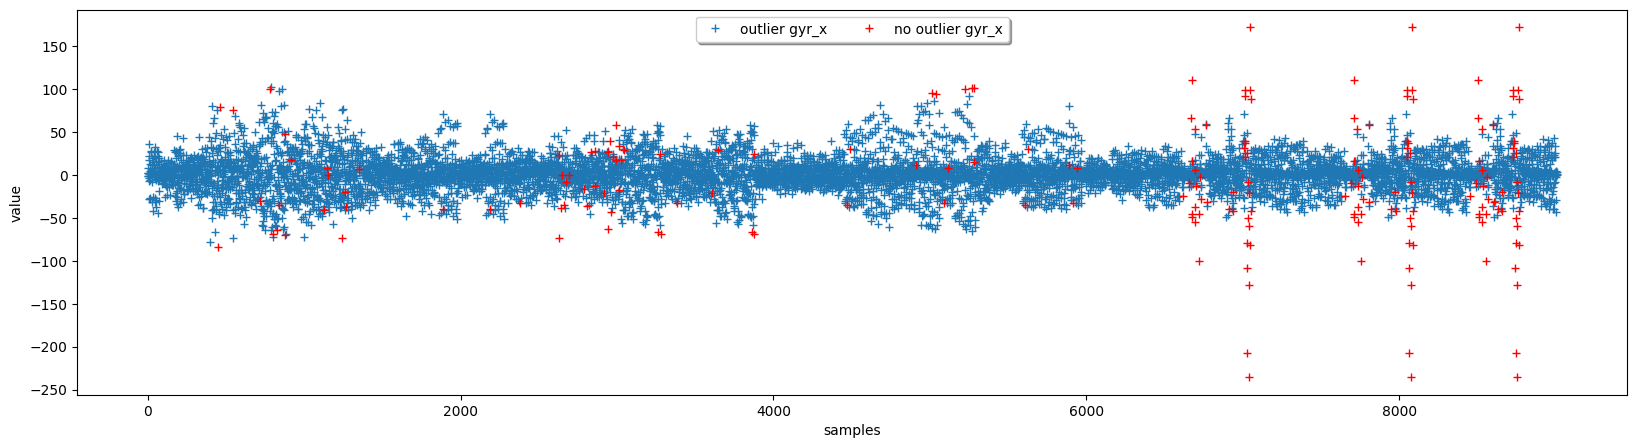

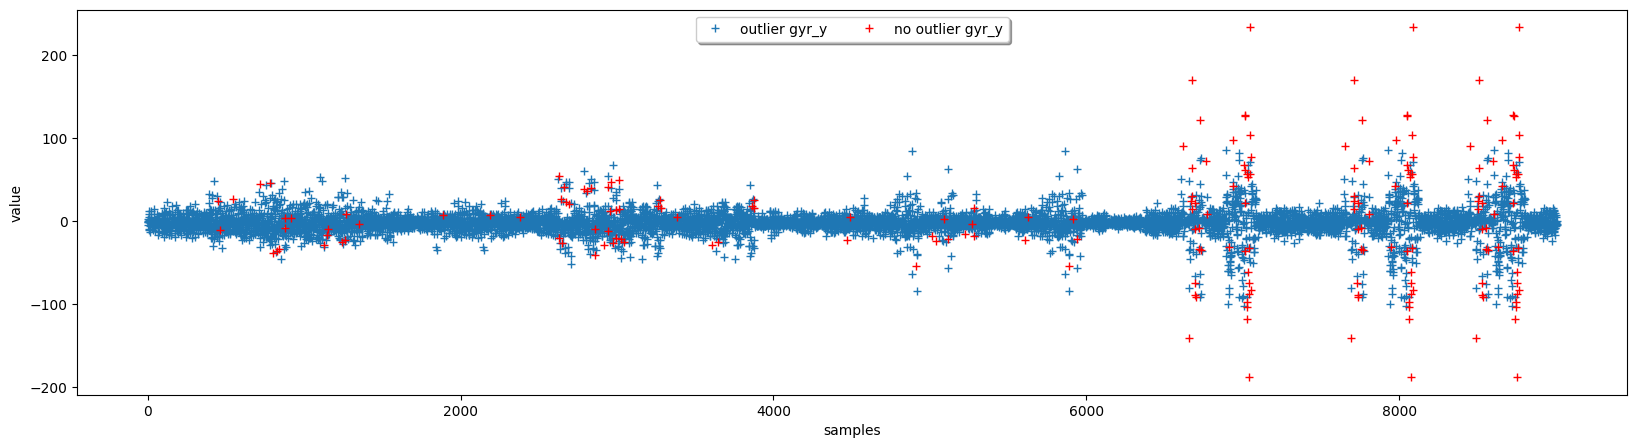

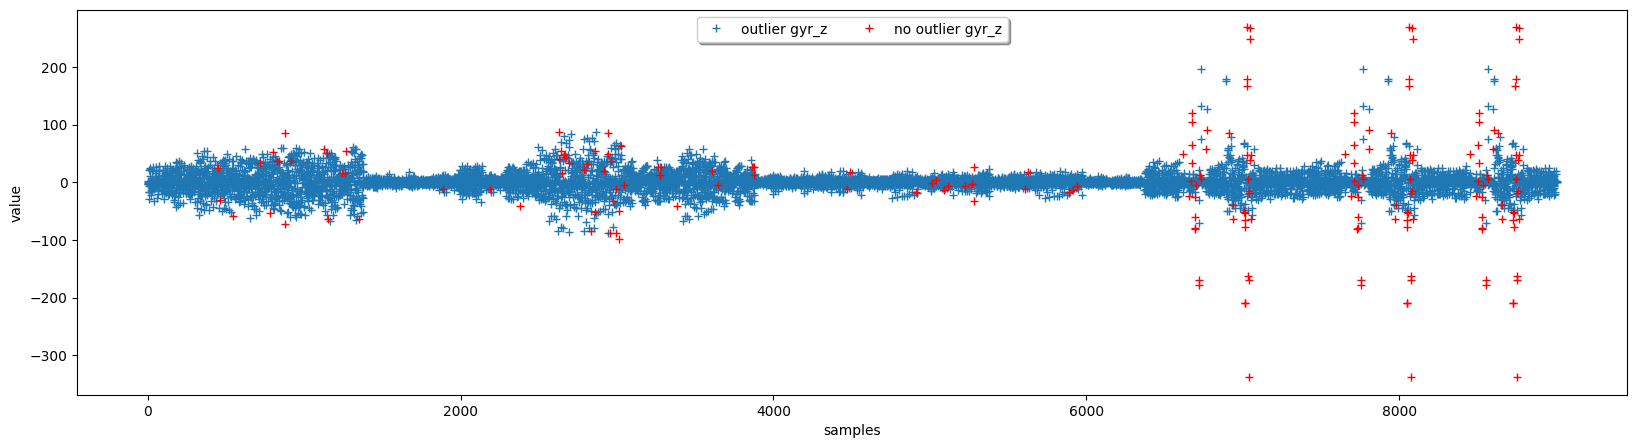

In [ ]:
dataset, outliers, X_scores = mark_outliers_lof(df, columns=list(df.columns)[:6])

for col in list(df.columns)[:6]:
    plot_binary_outliers(dataset, col=col, outlier_col= "outlier_lof", reset_index=True)

In [ ]:
outlier_removed = df.copy()
for col in list(df.columns)[:6]:
    for label in df['label'].unique():
        dataset = mark_outliers_chauvenet(df[df['label'] == label], col=col)
        dataset.loc[dataset[col+'_outlier'], col] = np.nan
        outlier_removed.loc[(outlier_removed['label'] == label), col] = dataset[col]

NameError: ignored

In [ ]:
outlier_removed.info()

NameError: ignored

In [ ]:
outlier_removed.to_csv('outlier_removed.csv')

# Feature Engineering

In [ ]:
df = outlier_removed

NameError: ignored

In [ ]:
predicator_cols = list(df.columns[:6])
predicator_cols

NameError: ignored

In [ ]:
for col in predicator_cols:
    df[col] = df[col].interpolate()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9009 entries, 2023-01-11 15:08:05.200 to 2023-01-20 17:33:27.800
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   acc_x        9009 non-null   float64
 1   acc_y        9009 non-null   float64
 2   acc_z        9009 non-null   float64
 3   gyr_x        9009 non-null   float64
 4   gyr_y        9009 non-null   float64
 5   gyr_z        9009 non-null   float64
 6   participant  9009 non-null   object 
 7   label        9009 non-null   object 
 8   category     9009 non-null   object 
 9   set          9009 non-null   int64  
dtypes: float64(6), int64(1), object(3)
memory usage: 1.0+ MB


In [ ]:
# Taken from https://github.com/mhoogen/ML4QS/blob/master/Python3Code/Chapter3/DataTransformation.py
from sklearn.decomposition import PCA

import copy
from scipy.signal import butter, lfilter, filtfilt

# This class removes the high frequency data (that might be considered noise) from the data.
class LowPassFilter:

    def low_pass_filter(self, data_table, col, sampling_frequency, cutoff_frequency, order=5, phase_shift=True):
        # http://stackoverflow.com/questions/12093594/how-to-implement-band-pass-butterworth-filter-with-scipy-signal-butter
        # Cutoff frequencies are expressed as the fraction of the Nyquist frequency, which is half the sampling frequency
        nyq = 0.5 * sampling_frequency
        cut = cutoff_frequency / nyq

        b, a = butter(order, cut, btype='low', output='ba', analog=False)
        if phase_shift:
            data_table[col + '_lowpass'] = filtfilt(b, a, data_table[col])
        else:
            data_table[col + '_lowpass'] = lfilter(b, a, data_table[col])
        return data_table

# Class for Principal Component Analysis. We can only apply this when we do not have missing values (i.e. NaN).
# For this we have to impute these first, be aware of this.
class PrincipalComponentAnalysis:

    pca = []

    def __init__(self):
        self.pca = []

    def normalize_dataset(self, data_table, columns):
        dt_norm = copy.deepcopy(data_table)
        for col in columns:
            dt_norm[col] = (data_table[col] - data_table[col].mean()) / (data_table[col].max() - data_table[col].min())
        return dt_norm

    # Perform the PCA on the selected columns and return the explained variance.
    def determine_pc_explained_variance(self, data_table, cols):
        # Normalize the data first.
        dt_norm = self.normalize_dataset(data_table, cols)

        # perform the PCA.
        self.pca = PCA(n_components = len(cols))
        self.pca.fit(dt_norm[cols])
        # And return the explained variances.
        return self.pca.explained_variance_ratio_

    # Apply a PCA given the number of components we have selected.
    # We add new pca columns.
    def apply_pca(self, data_table, cols, number_comp):
        # Normalize the data first.
        dt_norm = self.normalize_dataset(data_table, cols)

        # perform the PCA.
        self.pca = PCA(n_components = number_comp)
        self.pca.fit(dt_norm[cols])

        # Transform our old values.
        new_values = self.pca.transform(dt_norm[cols])

        #And add the new ones:
        for comp in range(0, number_comp):
            data_table['pca_' +str(comp+1)] = new_values[:,comp]

        return data_table

In [ ]:
df_lowpass = df.copy()
lowPass = LowPassFilter()

fs = 5
cutoff = 2
for col in predicator_cols:
    df_lowpass = lowPass.low_pass_filter(df_lowpass, col, fs, cutoff, order=5)
    df_lowpass[col] = df_lowpass[col + '_lowpass']
    del df_lowpass[col + '_lowpass']

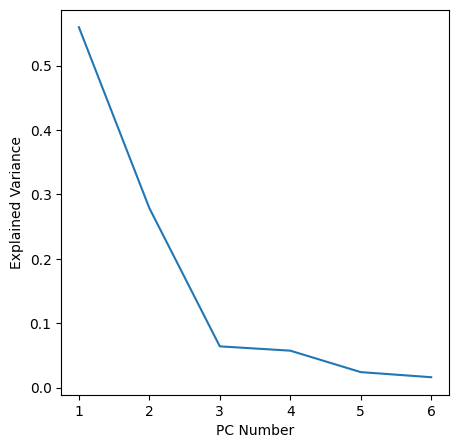

In [ ]:
df_pca = df.copy()
pca = PrincipalComponentAnalysis()

pc_values = pca.determine_pc_explained_variance(df_pca, predicator_cols)

plt.figure(figsize=(5,5))
plt.plot(range(1, len(predicator_cols)+1), pc_values)
plt.xlabel('PC Number')
plt.ylabel('Explained Variance')
plt.show()

In [ ]:
df_pca = pca.apply_pca(df_pca, predicator_cols, 3)
df_pca.head(5)

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,pca_1,pca_2,pca_3
epoch (ms),,,,,,,,,,,,,
2023-01-11 15:08:05.200,0.013500,0.977000,-0.071000,-1.8904,2.4392,0.9388,B,bench,heavy,30,-0.291270,-0.077753,-0.004902
2023-01-11 15:08:05.400,-0.001500,0.970500,-0.079500,-1.6826,-0.8904,2.1708,B,bench,heavy,30,-0.290466,-0.084844,-0.003489
2023-01-11 15:08:05.600,0.001333,0.971667,-0.064333,2.5608,-0.2560,-1.4146,B,bench,heavy,30,-0.290224,-0.075844,-0.024068
2023-01-11 15:08:05.800,-0.024000,0.957000,-0.073500,8.0610,-4.5244,-2.0730,B,bench,heavy,30,-0.287505,-0.084981,-0.045482
2023-01-11 15:08:06.000,-0.028000,0.957667,-0.115000,2.4390,-1.5486,-3.6098,B,bench,heavy,30,-0.289006,-0.108973,-0.024657


In [ ]:
df_squared = df_pca.copy()

acc_r = df_squared['acc_x'] ** 2 + df_squared['acc_y'] ** 2 + df_squared['acc_z'] ** 2
gyr_r = df_squared['gyr_x'] ** 2 + df_squared['gyr_y'] ** 2 + df_squared['gyr_z'] ** 2

df_squared['acc_r'] = np.sqrt(acc_r)
df_squared['gyr_r'] = np.sqrt(gyr_r)

df_squared.head(5)

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,pca_1,pca_2,pca_3,acc_r,gyr_r
epoch (ms),,,,,,,,,,,,,,,
2023-01-11 15:08:05.200,0.013500,0.977000,-0.071000,-1.8904,2.4392,0.9388,B,bench,heavy,30,-0.291270,-0.077753,-0.004902,0.979669,3.225625
2023-01-11 15:08:05.400,-0.001500,0.970500,-0.079500,-1.6826,-0.8904,2.1708,B,bench,heavy,30,-0.290466,-0.084844,-0.003489,0.973752,2.887270
2023-01-11 15:08:05.600,0.001333,0.971667,-0.064333,2.5608,-0.2560,-1.4146,B,bench,heavy,30,-0.290224,-0.075844,-0.024068,0.973795,2.936720
2023-01-11 15:08:05.800,-0.024000,0.957000,-0.073500,8.0610,-4.5244,-2.0730,B,bench,heavy,30,-0.287505,-0.084981,-0.045482,0.960118,9.473502
2023-01-11 15:08:06.000,-0.028000,0.957667,-0.115000,2.4390,-1.5486,-3.6098,B,bench,heavy,30,-0.289006,-0.108973,-0.024657,0.964953,4.623585


In [ ]:
import scipy.stats as stats

class NumericalAbstraction:



    # This function aggregates a list of values using the specified aggregation
    # function (which can be 'mean', 'max', 'min', 'median', 'std', 'slope')
    def aggregate_value(self, aggregation_function):
        # Compute the values and return the result.
        if aggregation_function == 'mean':
            return np.mean
        elif aggregation_function == 'max':
            return np.max
        elif aggregation_function == 'min':
            return np.min
        elif aggregation_function == 'median':
            return np.median
        elif aggregation_function == 'std':
            return np.std
        else:
            return np.nan


    def abstract_numerical(self, data_table, cols, window_size, aggregation_function):

        for col in cols:
            data_table[col + '_temp_' + aggregation_function + '_ws_' + str(window_size)] = (
                data_table[col].rolling(window_size).apply(self.aggregate_value(aggregation_function))
            )


        return data_table

class FourierTransformation:

    # Find the amplitudes of the different frequencies using a fast fourier transformation. Here,
    # the sampling rate expresses the number of samples per second (i.e. Frequency is Hertz of the dataset).
    def find_fft_transformation(self, data, sampling_rate):
        # Create the transformation, this includes the amplitudes of both the real
        # and imaginary part.
        transformation = np.fft.rfft(data, len(data))
        return transformation.real, transformation.imag

    # Get frequencies over a certain window.
    def abstract_frequency(self, data_table, cols, window_size, sampling_rate):

        # Create new columns for the frequency data.
        freqs = np.round((np.fft.rfftfreq(int(window_size)) * sampling_rate), 3)

        for col in cols:
            data_table[col + "_max_freq"] = np.nan
            data_table[col + "_freq_weighted"] = np.nan
            data_table[col + "_pse"] = np.nan
            for freq in freqs:
                data_table[
                    col + "_freq_" + str(freq) + "_Hz_ws_" + str(window_size)
                ] = np.nan

        # Pass over the dataset (we cannot compute it when we do not have enough history)
        # and compute the values.
        for i in range(window_size, len(data_table.index)):
            for col in cols:
                real_ampl, imag_ampl = self.find_fft_transformation(
                    data_table[col].iloc[
                        i - window_size : min(i + 1, len(data_table.index))
                    ],
                    sampling_rate,
                )
                # We only look at the real part in this implementation.
                for j in range(0, len(freqs)):
                    data_table.loc[
                        i, col + "_freq_" + str(freqs[j]) + "_Hz_ws_" + str(window_size)
                    ] = real_ampl[j]
                # And select the dominant frequency. We only consider the positive frequencies for now.

                data_table.loc[i, col + "_max_freq"] = freqs[
                    np.argmax(real_ampl[0 : len(real_ampl)])
                ]
                data_table.loc[i, col + "_freq_weighted"] = float(
                    np.sum(freqs * real_ampl)
                ) / np.sum(real_ampl)
                PSD = np.divide(np.square(real_ampl), float(len(real_ampl)))
                PSD_pdf = np.divide(PSD, np.sum(PSD))
                data_table.loc[i, col + "_pse"] = -np.sum(np.log(PSD_pdf) * PSD_pdf)

        return data_table

In [ ]:
df_temporal = df_squared.copy()

numAbs = NumericalAbstraction()

predicator_cols.append('acc_r')
predicator_cols.append('gyr_r')

ws = 5

for col in predicator_cols:
    df_temporal = numAbs.abstract_numerical(df_temporal, [col], ws, 'mean')
    df_temporal = numAbs.abstract_numerical(df_temporal, [col], ws, 'std')

df_temporal_list = []
for s in df_temporal['set'].unique():
    subset = df_temporal[df_temporal['set'] == s].copy()
    for col in predicator_cols:
        subset = numAbs.abstract_numerical(subset, [col], ws, 'mean')
        subset = numAbs.abstract_numerical(subset, [col], ws, 'std')
    df_temporal_list.append(subset)
df_temporal = pd.concat(df_temporal_list)

In [ ]:
df_freq = df_temporal.copy().reset_index()
freqAbc = FourierTransformation()


fs = 5
ws = 14


df_freq_list = []
for s in df_freq['set'].unique():
    subset = df_freq[df_freq['set'] == s].reset_index(drop=True).copy()
    subset = freqAbc.abstract_frequency(subset, predicator_cols, ws, fs)
    df_freq_list.append(subset)

df_freq = pd.concat(df_freq_list).set_index("epoch (ms)", drop=True)

<ipython-input-127-2b6d1dcbc8b5>:85: RuntimeWarning: divide by zero encountered in log
  data_table.loc[i, col + "_pse"] = -np.sum(np.log(PSD_pdf) * PSD_pdf)
<ipython-input-127-2b6d1dcbc8b5>:85: RuntimeWarning: invalid value encountered in multiply
  data_table.loc[i, col + "_pse"] = -np.sum(np.log(PSD_pdf) * PSD_pdf)
<ipython-input-127-2b6d1dcbc8b5>:85: RuntimeWarning: divide by zero encountered in log
  data_table.loc[i, col + "_pse"] = -np.sum(np.log(PSD_pdf) * PSD_pdf)
<ipython-input-127-2b6d1dcbc8b5>:85: RuntimeWarning: invalid value encountered in multiply
  data_table.loc[i, col + "_pse"] = -np.sum(np.log(PSD_pdf) * PSD_pdf)
<ipython-input-127-2b6d1dcbc8b5>:85: RuntimeWarning: divide by zero encountered in log
  data_table.loc[i, col + "_pse"] = -np.sum(np.log(PSD_pdf) * PSD_pdf)
<ipython-input-127-2b6d1dcbc8b5>:85: RuntimeWarning: invalid value encountered in multiply
  data_table.loc[i, col + "_pse"] = -np.sum(np.log(PSD_pdf) * PSD_pdf)
<ipython-input-127-2b6d1dcbc8b5>:85: Run

In [ ]:
df_freq

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,...,gyr_r_freq_weighted,gyr_r_pse,gyr_r_freq_0.0_Hz_ws_14,gyr_r_freq_0.357_Hz_ws_14,gyr_r_freq_0.714_Hz_ws_14,gyr_r_freq_1.071_Hz_ws_14,gyr_r_freq_1.429_Hz_ws_14,gyr_r_freq_1.786_Hz_ws_14,gyr_r_freq_2.143_Hz_ws_14,gyr_r_freq_2.5_Hz_ws_14
epoch (ms),,,,,,,,,,,,,,,,,,,,,
2023-01-11 15:08:05.200,0.013500,0.977000,-0.071000,-1.8904,2.4392,0.9388,B,bench,heavy,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-11 15:08:05.400,-0.001500,0.970500,-0.079500,-1.6826,-0.8904,2.1708,B,bench,heavy,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-11 15:08:05.600,0.001333,0.971667,-0.064333,2.5608,-0.2560,-1.4146,B,bench,heavy,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-11 15:08:05.800,-0.024000,0.957000,-0.073500,8.0610,-4.5244,-2.0730,B,bench,heavy,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-11 15:08:06.000,-0.028000,0.957667,-0.115000,2.4390,-1.5486,-3.6098,B,bench,heavy,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-20 17:33:27.000,-0.048000,-1.041500,-0.076500,1.4146,-5.6218,0.2926,E,row,medium,90,...,-0.509953,0.262948,328.071360,-39.663900,29.883610,2.546553,-10.284092,-56.000494,-12.039831,2.305583
2023-01-20 17:33:27.200,-0.037000,-1.030333,-0.053333,-2.7684,-0.5854,2.2440,E,row,medium,90,...,0.473771,0.732701,320.911687,-42.569654,76.976748,94.956625,-42.364853,56.210236,23.009160,0.081362
2023-01-20 17:33:27.400,-0.060000,-1.031000,-0.082000,2.8416,-5.1342,-0.1220,E,row,medium,90,...,0.670073,0.650708,283.213668,-65.393909,55.066161,51.650214,30.240947,25.798940,12.468238,41.569150


In [ ]:
df_freq = df_freq.dropna()
df_freq = df_freq.iloc[::2]

In [ ]:
df_freq

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,...,gyr_r_freq_weighted,gyr_r_pse,gyr_r_freq_0.0_Hz_ws_14,gyr_r_freq_0.357_Hz_ws_14,gyr_r_freq_0.714_Hz_ws_14,gyr_r_freq_1.071_Hz_ws_14,gyr_r_freq_1.429_Hz_ws_14,gyr_r_freq_1.786_Hz_ws_14,gyr_r_freq_2.143_Hz_ws_14,gyr_r_freq_2.5_Hz_ws_14
epoch (ms),,,,,,,,,,,,,,,,,,,,,
2023-01-11 15:08:08.000,-0.184333,0.991333,-0.190667,-28.4268,-13.0854,25.2684,B,bench,heavy,30,...,-1.125052,0.600298,245.584138,-48.335782,16.723521,22.887133,-16.462033,13.505075,-90.019558,3.101760
2023-01-11 15:08:08.400,-0.011000,0.850667,-0.094333,12.0852,-0.3536,-5.4024,B,bench,heavy,30,...,-0.624244,0.277713,289.009998,-39.531353,-29.027394,-41.172091,-2.880020,5.499492,-21.546180,6.177948
2023-01-11 15:08:08.800,-0.065000,0.955333,-0.025333,1.2684,-3.0246,-1.2318,B,bench,heavy,30,...,-0.247681,0.540112,286.688181,-50.110861,-55.030849,2.663819,-12.836489,-45.736718,57.967366,-5.583470
2023-01-11 15:08:09.200,-0.040667,0.990000,-0.034000,2.8538,-2.9390,1.8656,B,bench,heavy,30,...,0.498083,0.476851,283.912877,-28.514942,38.213692,33.033641,23.097709,34.991662,52.306514,-21.177484
2023-01-11 15:08:09.600,-0.054000,0.946333,-0.068000,2.1586,2.7194,-3.8658,B,bench,heavy,30,...,-0.768731,0.590682,230.374271,-26.239333,38.922872,-34.668524,1.381463,34.560586,-24.313563,-49.567671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-20 17:33:26.000,0.023333,-0.483667,0.200000,-8.7926,9.3658,0.1342,E,row,medium,90,...,-0.328237,0.482764,347.170845,-17.559995,-55.354330,-91.103222,16.167516,48.095862,-25.078565,5.347692
2023-01-20 17:33:26.400,0.001667,-1.267667,-0.078667,-29.7804,4.6464,18.9510,E,row,medium,90,...,-0.271730,0.448131,412.697542,61.755348,-24.017146,77.520934,-46.187130,-64.070276,-21.072239,10.783815
2023-01-20 17:33:26.800,-0.032333,-1.001000,-0.074667,4.4754,-3.4146,1.8780,E,row,medium,90,...,0.363229,0.429302,347.669692,-16.842251,-22.177096,-75.996897,64.861537,22.968427,21.862325,22.009788


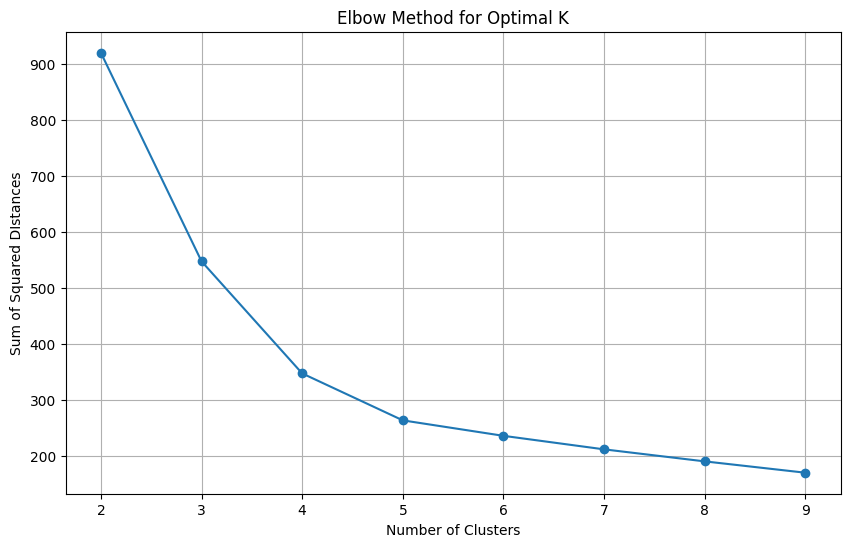

In [ ]:
df_cluster = df_freq.copy()
cluster_cols = ['acc_x', 'acc_y', 'acc_z']

k_vals = range(2, 10)
inertias = []

subset = df_cluster[cluster_cols]

for k in k_vals:
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=0)
    clusters = kmeans.fit_predict(subset)
    inertias.append(kmeans.inertia_)


plt.figure(figsize=(10, 6))
plt.plot(k_vals, inertias, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared DIstances')
plt.grid(True)
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=5, n_init=20, random_state=0)
df_cluster['cluster'] = kmeans.fit_predict(subset)

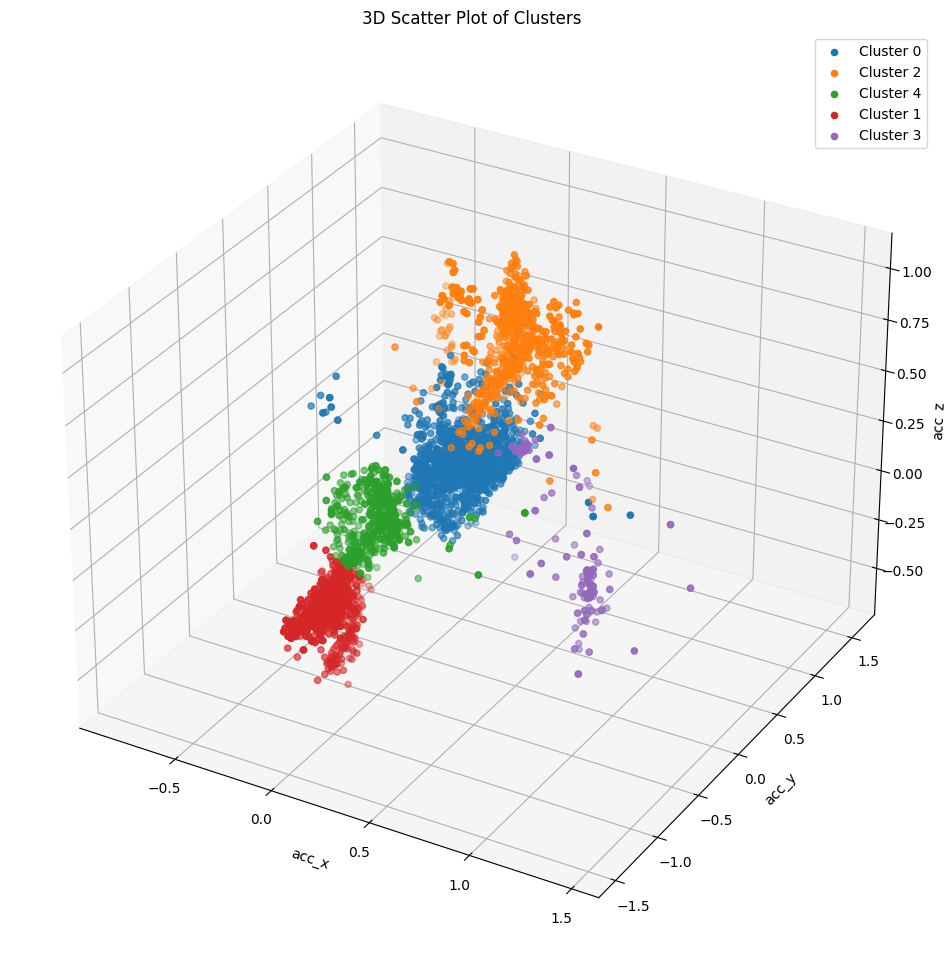

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

for c in df_cluster['cluster'].unique():
    cluster_data = df_cluster[df_cluster['cluster'] == c]
    ax.scatter(cluster_data['acc_x'], cluster_data['acc_y'], cluster_data['acc_z'],
               label=f'Cluster {c}')

ax.set_xlabel('acc_x')
ax.set_ylabel('acc_y')
ax.set_zlabel('acc_z')
ax.set_title('3D Scatter Plot of Clusters')
ax.legend()

plt.show()

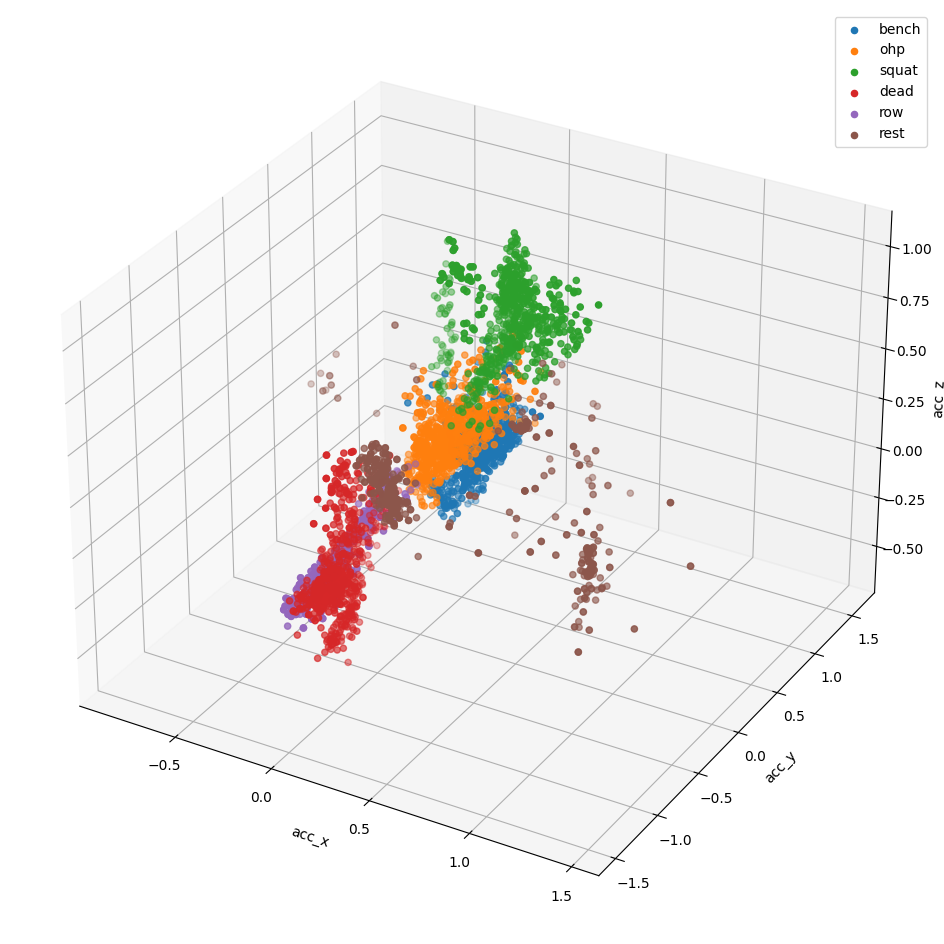

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

for l in df_cluster['label'].unique():
    cluster_data = df_cluster[df_cluster['label'] == l]
    ax.scatter(cluster_data['acc_x'], cluster_data['acc_y'], cluster_data['acc_z'],
               label=f'{l}')

ax.set_xlabel('acc_x')
ax.set_ylabel('acc_y')
ax.set_zlabel('acc_z')
ax.legend()

plt.show()

In [ ]:
df_cluster.to_csv('cluster_data.csv')

# Predictive Modeling

In [ ]:
# df = df_cluster
df = pd.read_csv('cluster_data.csv', index_col=0)
df

,acc_x,acc_y,acc_z,gyr_x,gyr_y,gyr_z,participant,label,category,set,...,gyr_r_pse,gyr_r_freq_0.0_Hz_ws_14,gyr_r_freq_0.357_Hz_ws_14,gyr_r_freq_0.714_Hz_ws_14,gyr_r_freq_1.071_Hz_ws_14,gyr_r_freq_1.429_Hz_ws_14,gyr_r_freq_1.786_Hz_ws_14,gyr_r_freq_2.143_Hz_ws_14,gyr_r_freq_2.5_Hz_ws_14,cluster
epoch (ms),,,,,,,,,,,,,,,,,,,,,
2023-01-11 15:08:08.000,-0.184333,0.991333,-0.190667,-28.4268,-13.0854,25.2684,B,bench,heavy,30,...,0.600298,245.584138,-48.335782,16.723521,22.887133,-16.462033,13.505075,-90.019558,3.101760,0
2023-01-11 15:08:08.400,-0.011000,0.850667,-0.094333,12.0852,-0.3536,-5.4024,B,bench,heavy,30,...,0.277713,289.009998,-39.531353,-29.027394,-41.172091,-2.880020,5.499492,-21.546180,6.177948,0
2023-01-11 15:08:08.800,-0.065000,0.955333,-0.025333,1.2684,-3.0246,-1.2318,B,bench,heavy,30,...,0.540112,286.688181,-50.110861,-55.030849,2.663819,-12.836489,-45.736718,57.967366,-5.583470,0
2023-01-11 15:08:09.200,-0.040667,0.990000,-0.034000,2.8538,-2.9390,1.8656,B,bench,heavy,30,...,0.476851,283.912877,-28.514942,38.213692,33.033641,23.097709,34.991662,52.306514,-21.177484,0
2023-01-11 15:08:09.600,-0.054000,0.946333,-0.068000,2.1586,2.7194,-3.8658,B,bench,heavy,30,...,0.590682,230.374271,-26.239333,38.922872,-34.668524,1.381463,34.560586,-24.313563,-49.567671,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-20 17:33:26.000,0.023333,-0.483667,0.200000,-8.7926,9.3658,0.1342,E,row,medium,90,...,0.482764,347.170845,-17.559995,-55.354330,-91.103222,16.167516,48.095862,-25.078565,5.347692,4
2023-01-20 17:33:26.400,0.001667,-1.267667,-0.078667,-29.7804,4.6464,18.9510,E,row,medium,90,...,0.448131,412.697542,61.755348,-24.017146,77.520934,-46.187130,-64.070276,-21.072239,10.783815,1
2023-01-20 17:33:26.800,-0.032333,-1.001000,-0.074667,4.4754,-3.4146,1.8780,E,row,medium,90,...,0.429302,347.669692,-16.842251,-22.177096,-75.996897,64.861537,22.968427,21.862325,22.009788,1


In [ ]:
df_train = df.drop(['set', 'participant', 'category'], axis=1)
x_df = df_train.drop(['label'], axis=1)
y_df = df_train['label']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, test_size=0.25,
                                                    random_state=42, stratify=y_df)

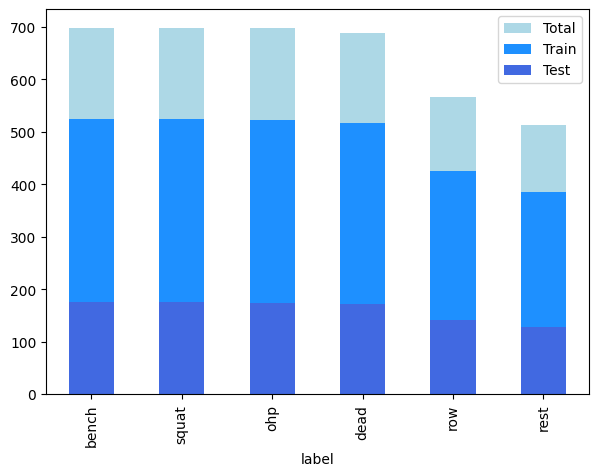

In [ ]:
plt.figure(figsize=(7,5))
df_train['label'].value_counts().plot(kind='bar', color='lightblue', label='Total')
y_train.value_counts().plot(kind='bar', color='dodgerblue', label='Train')
y_test.value_counts().plot(kind='bar', color='royalblue', label='Test')
plt.legend()
plt.show()

In [ ]:
basic_features = ['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']
square_features = ['acc_r', 'gyr_r']
pca_features = ['pca_1', 'pca_2', 'pca_3']
time_features = [f for f in df.columns if '_temp_' in f]
freq_features = [f for f in df.columns if ('_freq_' in f) or ('_pse' in f)]
cluster_features = ['cluster']

f_set1 = list(set(basic_features))
f_set2 = list(set(basic_features + square_features + pca_features))
f_set3 = list(set(f_set2 + time_features))
f_set4 = list(set(f_set3 + freq_features + cluster_features))


In [ ]:
learner = ClassificationAlgorithms()
selected_features, ordered_features, ordered_scores = learner.forward_selection(
    max_features=10, X_train=x_train, y_train=y_train
)

In [ ]:
selected_features = ['pca_2',
  'acc_x_freq_0.0_Hz_ws_14',
  'acc_z_freq_0.0_Hz_ws_14',
  'gyr_z_temp_mean_ws_5',
  'gyr_r_freq_1.429_Hz_ws_14',
  'gyr_r_freq_2.5_Hz_ws_14',
  'gyr_x_max_freq',
  'gyr_y_freq_weighted',
  'gyr_x_freq_2.5_Hz_ws_14',
  'acc_z_freq_1.786_Hz_ws_14']
selected_features

['pca_2',
 'acc_x_freq_0.0_Hz_ws_14',
 'acc_z_freq_0.0_Hz_ws_14',
 'gyr_z_temp_mean_ws_5',
 'gyr_r_freq_1.429_Hz_ws_14',
 'gyr_r_freq_2.5_Hz_ws_14',
 'gyr_x_max_freq',
 'gyr_y_freq_weighted',
 'gyr_x_freq_2.5_Hz_ws_14',
 'acc_z_freq_1.786_Hz_ws_14']

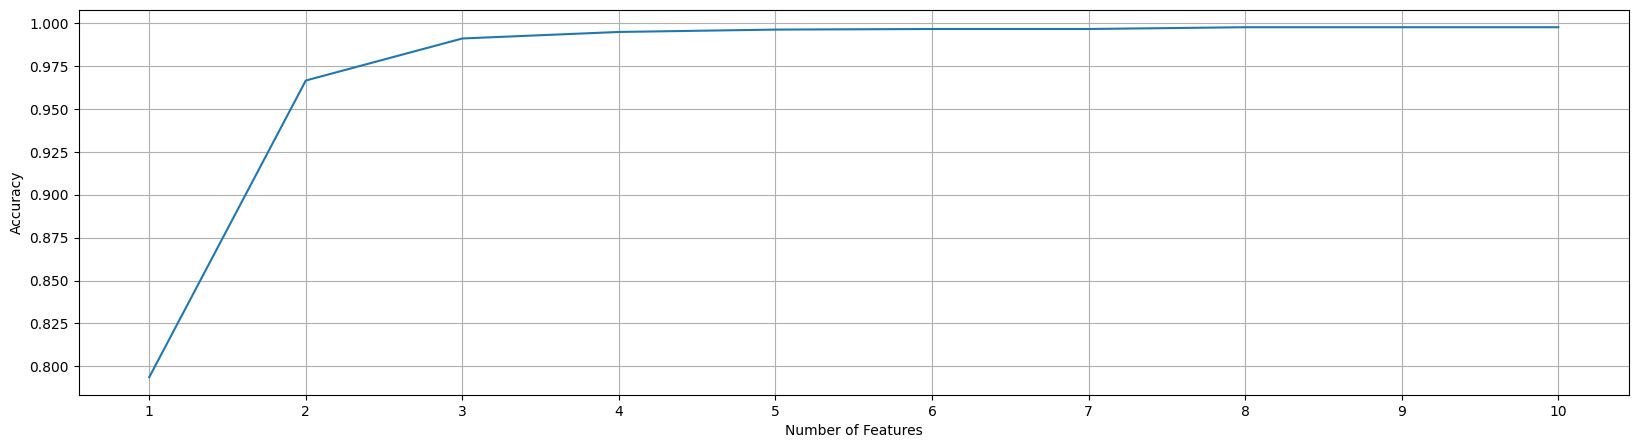

In [ ]:
plt.plot(np.arange(1, 11, 1), ordered_scores)
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.xticks(np.arange(1, 11, 1))
plt.grid(True)
plt.show()

In [ ]:
possible_feature_sets = [
    f_set1, f_set2, f_set3, f_set4, selected_features
]

feature_names = [
    'Feature Set 1', 'Feature Set 2', 'Feature Set 3', 'Feature Set 4', 'Selected Features',
]

iterations = 1
score_df = pd.DataFrame()

In [ ]:
for i, f in zip(range(len(possible_feature_sets)), feature_names):
    print("Feature set:", i)
    selected_train_X = x_train[possible_feature_sets[i]]
    selected_test_X = x_test[possible_feature_sets[i]]

    # First run non deterministic classifiers to average their score.
    performance_test_nn = 0
    performance_test_rf = 0

    for it in range(0, iterations):
        print("\tTraining neural network,", it)
        (
            class_train_y,
            class_test_y,
            class_train_prob_y,
            class_test_prob_y,
        ) = learner.feedforward_neural_network(
            selected_train_X,
            y_train,
            selected_test_X,
            gridsearch=False,
        )
        performance_test_nn += accuracy_score(y_test, class_test_y)

        print("\tTraining random forest,", it)
        (
            class_train_y,
            class_test_y,
            class_train_prob_y,
            class_test_prob_y,
        ) = learner.random_forest(
            selected_train_X, y_train, selected_test_X, gridsearch=True
        )
        performance_test_rf += accuracy_score(y_test, class_test_y)

    performance_test_nn = performance_test_nn / iterations
    performance_test_rf = performance_test_rf / iterations

    # And we run our deterministic classifiers:
    print("\tTraining KNN")
    (
        class_train_y,
        class_test_y,
        class_train_prob_y,
        class_test_prob_y,
    ) = learner.k_nearest_neighbor(
        selected_train_X, y_train, selected_test_X, gridsearch=True
    )
    performance_test_knn = accuracy_score(y_test, class_test_y)

    print("\tTraining decision tree")
    (
        class_train_y,
        class_test_y,
        class_train_prob_y,
        class_test_prob_y,
    ) = learner.decision_tree(
        selected_train_X, y_train, selected_test_X, gridsearch=True
    )
    performance_test_dt = accuracy_score(y_test, class_test_y)

    print("\tTraining naive bayes")
    (
        class_train_y,
        class_test_y,
        class_train_prob_y,
        class_test_prob_y,
    ) = learner.naive_bayes(selected_train_X, y_train, selected_test_X)

    performance_test_nb = accuracy_score(y_test, class_test_y)

    # Save results to dataframe
    models = ["NN", "RF", "KNN", "DT", "NB"]
    new_scores = pd.DataFrame(
        {
            "model": models,
            "feature_set": f,
            "accuracy": [
                performance_test_nn,
                performance_test_rf,
                performance_test_knn,
                performance_test_dt,
                performance_test_nb,
            ],
        }
    )
    score_df = pd.concat([score_df, new_scores])

Feature set: 0
	Training neural network, 0
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes
Feature set: 1
	Training neural network, 0
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes
Feature set: 2
	Training neural network, 0
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes
Feature set: 3
	Training neural network, 0
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes
Feature set: 4
	Training neural network, 0
	Training random forest, 0
	Training KNN
	Training decision tree
	Training naive bayes


In [ ]:
score_df.sort_values(by='accuracy', ascending=False)


,model,feature_set,accuracy
1,RF,Feature Set 4,0.993789
0,NN,Feature Set 4,0.984472
0,NN,Feature Set 3,0.984472
1,RF,Selected Features,0.983437
1,RF,Feature Set 3,0.980331
3,DT,Feature Set 4,0.976190
4,NB,Feature Set 4,0.967909
3,DT,Selected Features,0.960663
0,NN,Selected Features,0.959627
2,KNN,Feature Set 4,0.956522


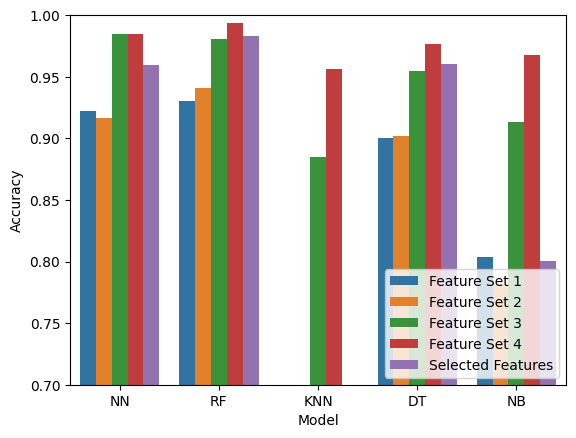

In [ ]:
sns.barplot(x='model', y='accuracy', hue='feature_set', data=score_df)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0.7, 1)
plt.legend(loc='lower right')
plt.show()

In [ ]:
(
    class_train_y,
    class_test_y,
    class_train_prob_y,
    class_test_prob_y
) = learner.random_forest(
    x_train[f_set4], y_train, x_test[f_set4], gridsearch=True
    )

In [ ]:
acc = accuracy_score(y_test, class_test_y)
print(f'Accuracy of the model is {acc}')

Accuracy of the model is 0.9937888198757764


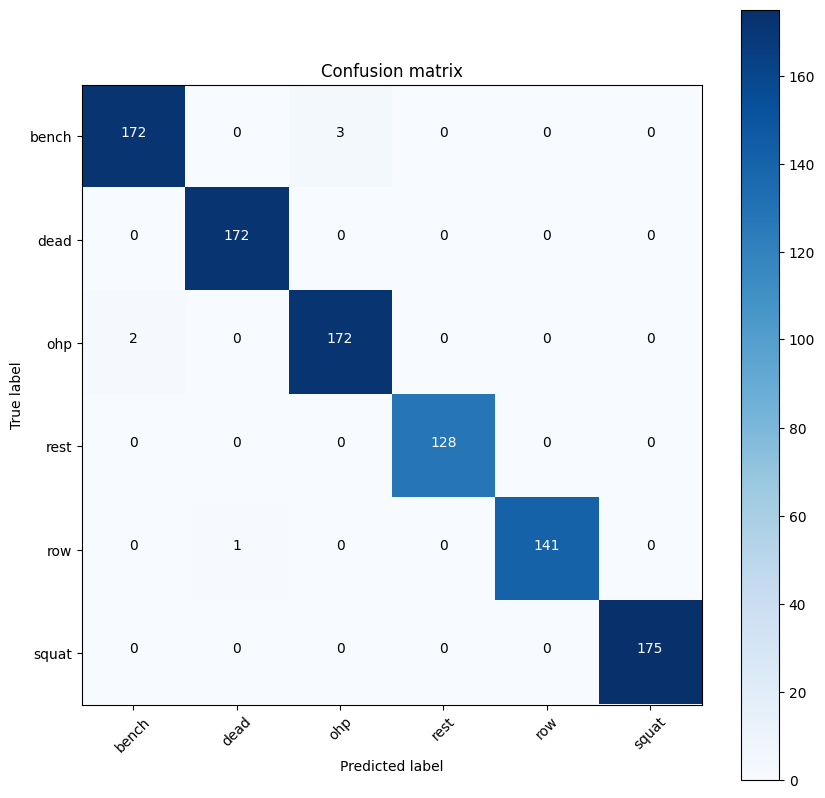

In [ ]:
classes = class_test_prob_y.columns
cm = confusion_matrix(y_test, class_test_y, labels=classes)

# create confusion matrix for cm
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(
        j,
        i,
        format(cm[i, j]),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black",
    )
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.grid(False)
plt.show()

## Participant-Based Data Split

In [ ]:
participant_df = df.drop(['set', 'category'], axis=1)
x_train = participant_df[participant_df['participant'] != 'A'].drop('label', axis=1)
y_train = participant_df[participant_df['participant'] != 'A']['label']

x_test = participant_df[participant_df['participant'] == 'A'].drop('label', axis=1)
y_test = participant_df[participant_df['participant'] == 'A']['label']

x_train = x_train.drop(['participant'], axis=1)
x_test = x_test.drop(['participant'], axis=1)



In [ ]:
(
    class_train_y,
    class_test_y,
    class_train_prob_y,
    class_test_prob_y
) = learner.feedforward_neural_network(
    x_train[f_set4], y_train, x_test[f_set4], gridsearch=False
    )

In [ ]:
acc = accuracy_score(y_test, class_test_y)
print(f'Accuracy of the model is {acc}')

Accuracy of the model is 0.991466252909232


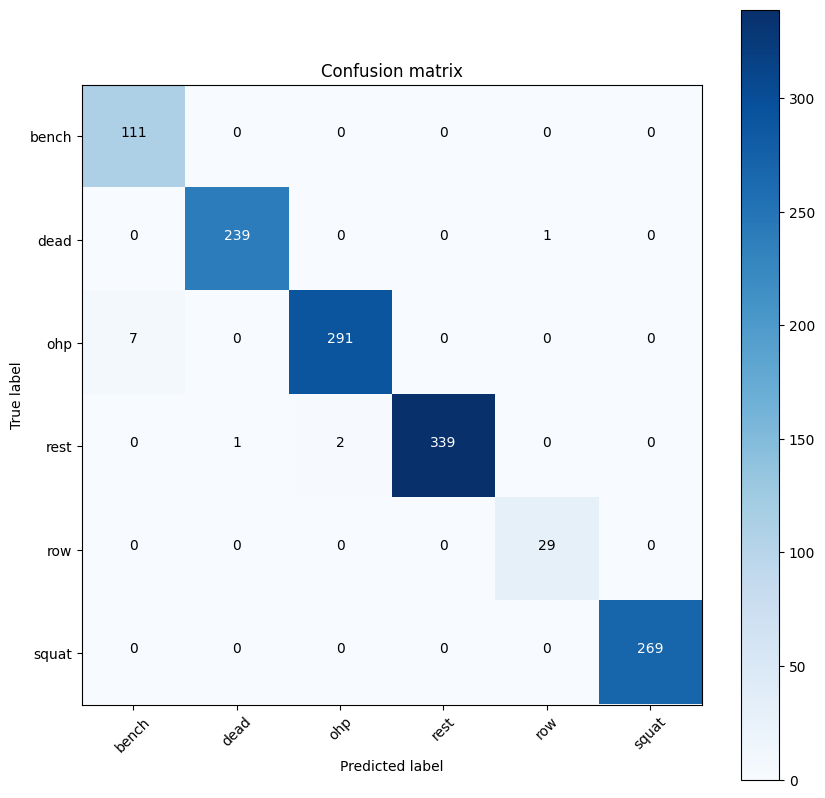

In [ ]:
classes = class_test_prob_y.columns
cm = confusion_matrix(y_test, class_test_y, labels=classes)

# create confusion matrix for cm
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.0
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(
        j,
        i,
        format(cm[i, j]),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black",
    )
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.grid(False)
plt.show()